# Volatility Regime Visualization (2024-2025)

This notebook visualizes volatility regimes across different time periods to understand market conditions.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from src.alpaca_loader import StockClient
from src.regimes import RegimeDetector, AdaptiveRegimeDetector, VolatilityRegime

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## 1. Load Historical Data

In [4]:
# Configuration
SYMBOLS = ['AAPL', 'MSFT', 'NVDA', 'TSLA']  # Add more symbols as needed
LOOKBACK_DAYS = 730  # 2 years to cover 2024 and 2025

print(f"Loading data for {SYMBOLS}...")
loader = StockClient()

# Load data
data = loader.get_history(SYMBOLS, lookback=LOOKBACK_DAYS, interval='minute')
print(f"Data loaded: {data.shape[0]} bars")
print(f"Date range: {data.index.get_level_values('timestamp').min()} to {data.index.get_level_values('timestamp').max()}")

Loading data for ['AAPL', 'MSFT', 'NVDA', 'TSLA']...
Data loaded: 755845 bars
Date range: 2023-12-18 14:30:00+00:00 to 2025-12-16 21:48:00+00:00


## 2. Calculate Volatility Regimes

In [5]:
def calculate_regimes_for_symbol(symbol, data, lookback_window=390, regime_window=20):
    """
    Calculate volatility regimes for a single symbol.
    """
    detector = RegimeDetector(lookback_window=lookback_window, regime_window=regime_window)
    
    # Get symbol data
    symbol_data = data.xs(symbol, level='symbol')
    
    regimes = []
    volatilities = []
    percentiles = []
    timestamps = []
    
    print(f"Processing {symbol}...")
    for idx, row in symbol_data.iterrows():
        bar = {'close': row['close']}
        regime = detector.on_bar(symbol, bar)
        
        regimes.append(regime.value)
        volatilities.append(detector.get_volatility(symbol))
        percentiles.append(detector.get_percentile(symbol))
        timestamps.append(idx)
    
    return pd.DataFrame({
        'timestamp': timestamps,
        'regime': regimes,
        'volatility': volatilities,
        'percentile': percentiles,
        'close': symbol_data['close'].values
    }).set_index('timestamp')

# Calculate regimes for all symbols
regime_data = {}
for symbol in SYMBOLS:
    regime_data[symbol] = calculate_regimes_for_symbol(symbol, data)
    print(f"  {symbol}: {len(regime_data[symbol])} data points")

Processing AAPL...
  AAPL: 192655 data points
Processing MSFT...
  MSFT: 176315 data points
Processing NVDA...
  NVDA: 195460 data points
Processing TSLA...
  TSLA: 191415 data points


## 3. Visualize Regimes Over Time

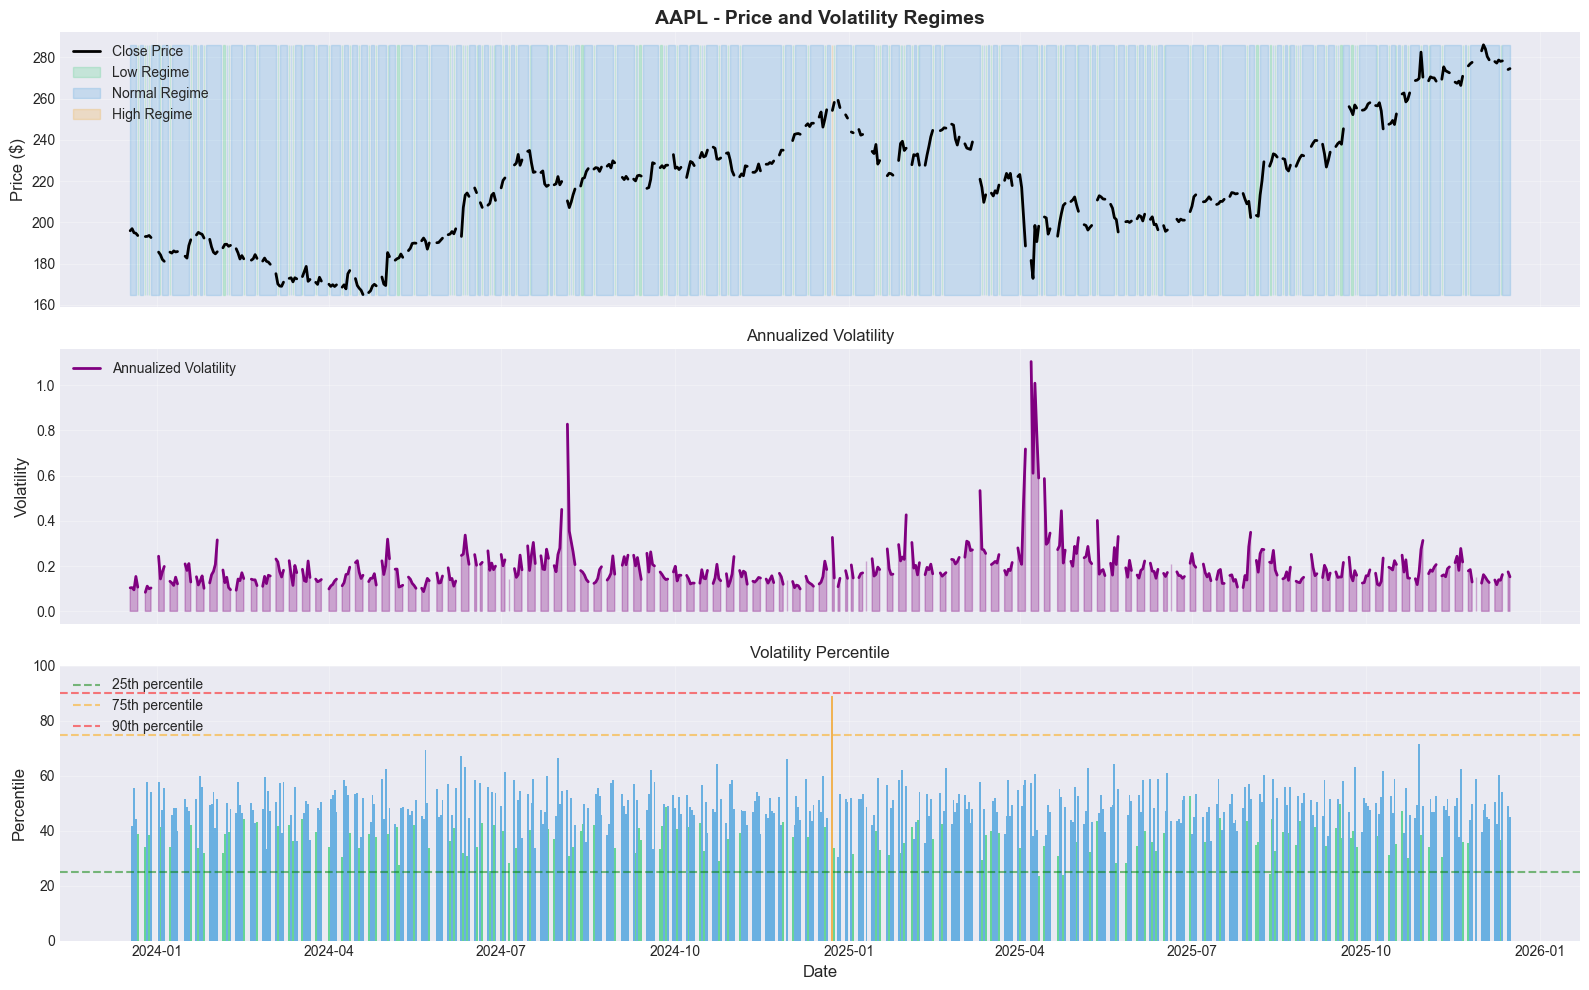

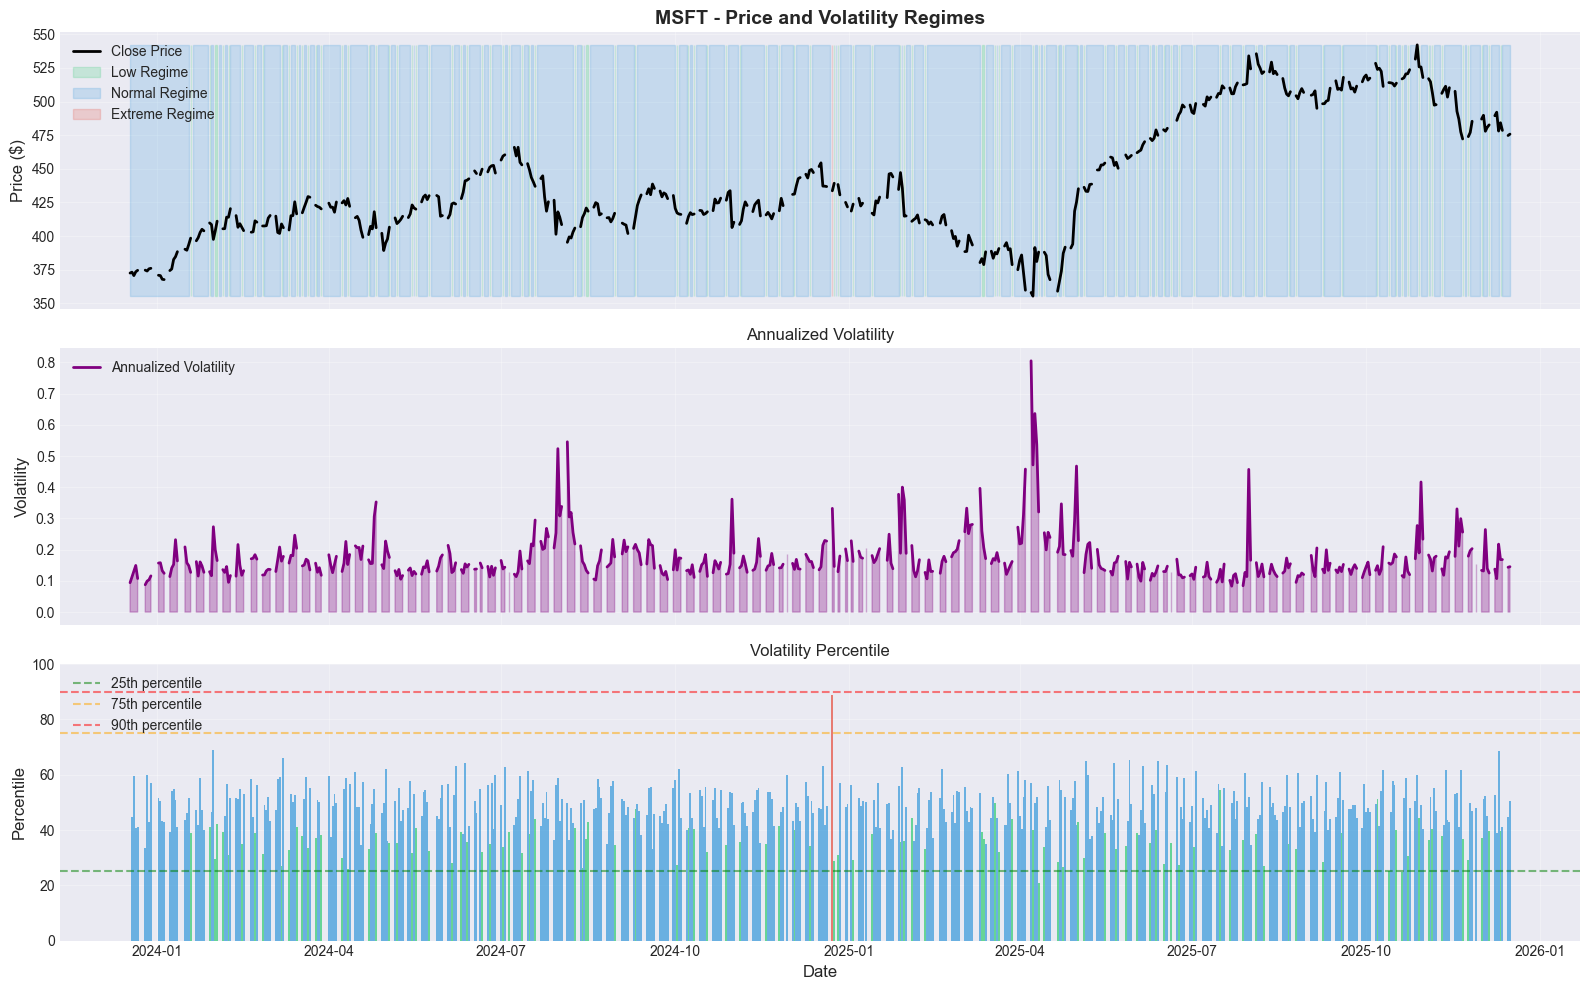

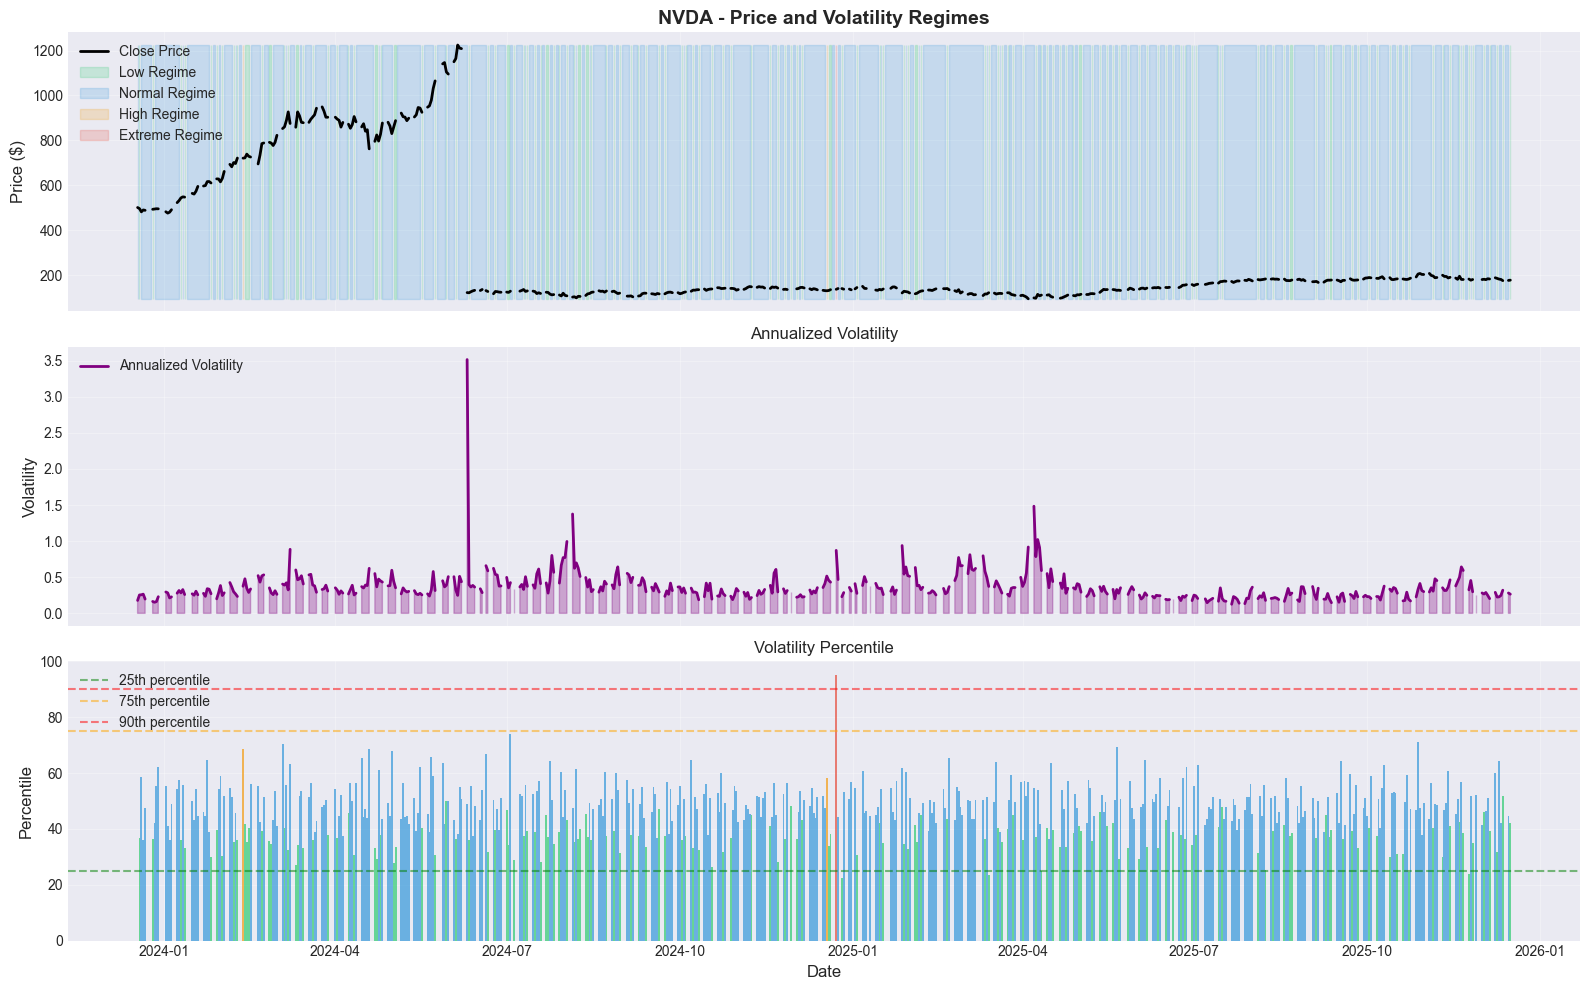

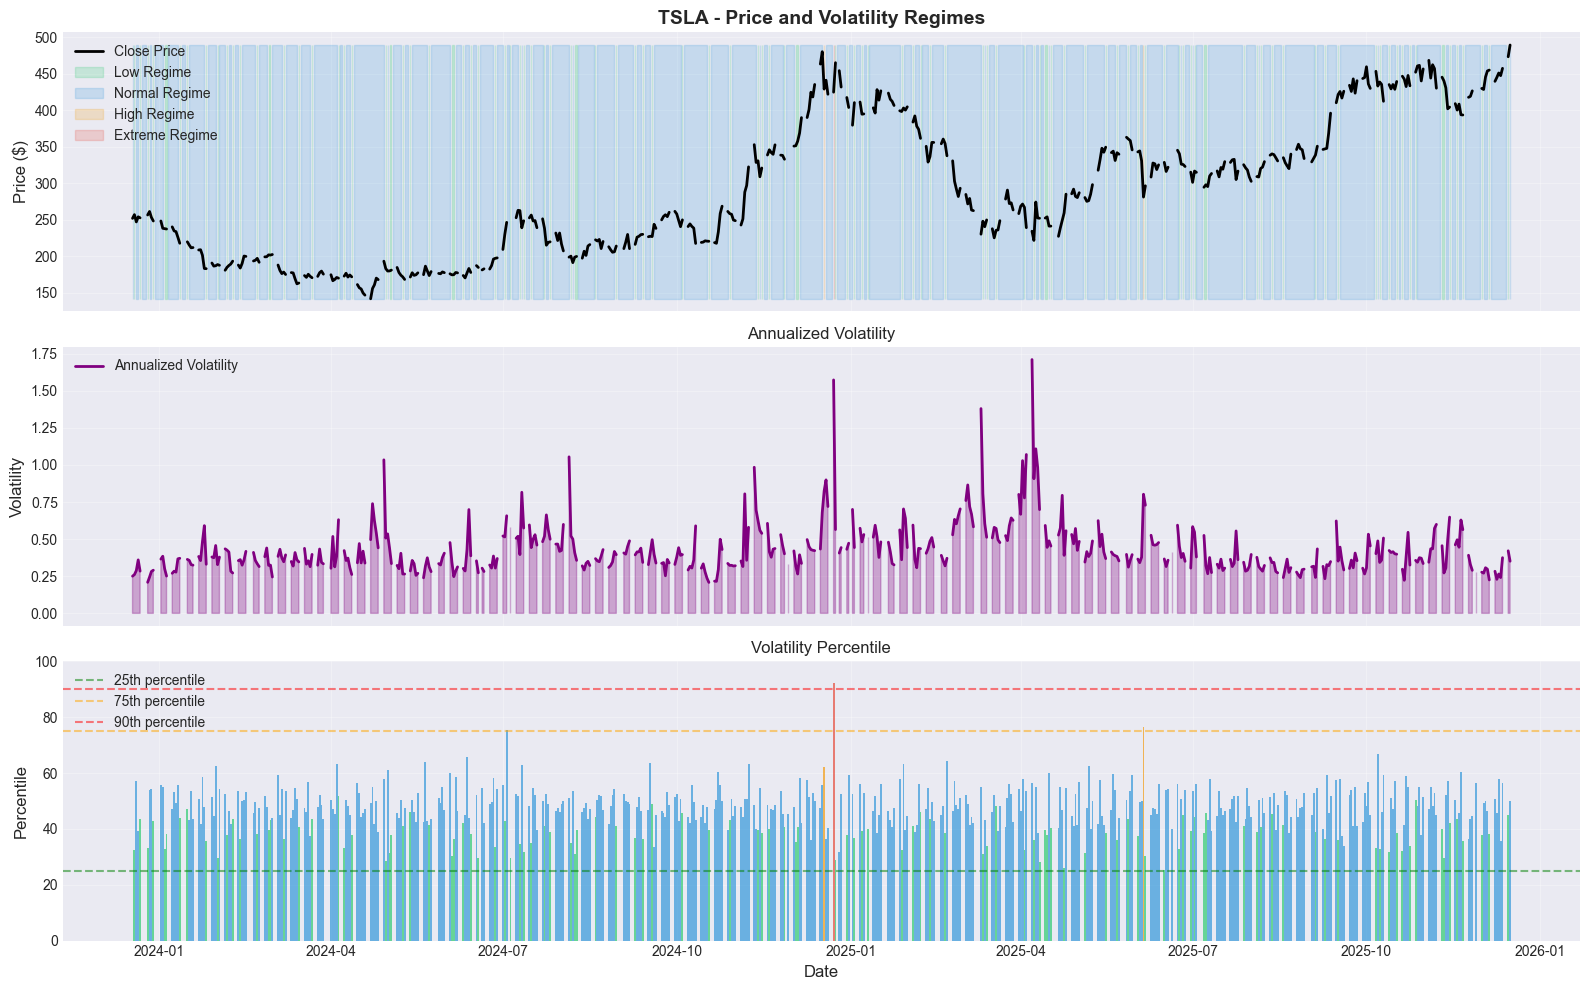

In [6]:
# Define regime colors
regime_colors = {
    'low': '#2ecc71',      # Green
    'normal': '#3498db',   # Blue
    'high': '#f39c12',     # Orange
    'extreme': '#e74c3c'   # Red
}

def plot_regime_timeline(symbol, df, resample='D'):
    """
    Plot regime timeline with price overlay.
    """
    # Resample to daily for cleaner visualization
    df_daily = df.resample(resample).agg({
        'regime': lambda x: x.mode()[0] if len(x) > 0 else 'normal',
        'volatility': 'mean',
        'percentile': 'mean',
        'close': 'last'
    })
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 10), sharex=True)
    
    # Plot 1: Price with regime background
    ax1.plot(df_daily.index, df_daily['close'], linewidth=2, color='black', label='Close Price')
    
    # Color background by regime
    for regime, color in regime_colors.items():
        mask = df_daily['regime'] == regime
        if mask.any():
            ax1.fill_between(df_daily.index, df_daily['close'].min(), df_daily['close'].max(),
                           where=mask, alpha=0.2, color=color, label=f'{regime.capitalize()} Regime')
    
    ax1.set_ylabel('Price ($)', fontsize=12)
    ax1.set_title(f'{symbol} - Price and Volatility Regimes', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Volatility over time
    ax2.plot(df_daily.index, df_daily['volatility'], linewidth=2, color='purple', label='Annualized Volatility')
    ax2.fill_between(df_daily.index, 0, df_daily['volatility'], alpha=0.3, color='purple')
    ax2.set_ylabel('Volatility', fontsize=12)
    ax2.set_title('Annualized Volatility', fontsize=12)
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Regime percentile
    colors = [regime_colors[r] for r in df_daily['regime']]
    ax3.bar(df_daily.index, df_daily['percentile'], color=colors, alpha=0.7, width=1)
    ax3.axhline(y=25, color='green', linestyle='--', alpha=0.5, label='25th percentile')
    ax3.axhline(y=75, color='orange', linestyle='--', alpha=0.5, label='75th percentile')
    ax3.axhline(y=90, color='red', linestyle='--', alpha=0.5, label='90th percentile')
    ax3.set_ylabel('Percentile', fontsize=12)
    ax3.set_xlabel('Date', fontsize=12)
    ax3.set_title('Volatility Percentile', fontsize=12)
    ax3.set_ylim(0, 100)
    ax3.legend(loc='upper left')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Plot for each symbol
for symbol in SYMBOLS:
    fig = plot_regime_timeline(symbol, regime_data[symbol])
    plt.show()

## 4. Regime Distribution Analysis

In [ ]:
def plot_regime_distribution(regime_data_dict):
    """
    Plot regime distribution across all symbols.
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    for idx, (symbol, df) in enumerate(regime_data_dict.items()):
        if idx >= 4:
            break
            
        # Count regimes
        regime_counts = df['regime'].value_counts()
        regime_pcts = (regime_counts / len(df) * 100).round(1)
        
        # Plot pie chart
        colors = [regime_colors.get(r, 'gray') for r in regime_counts.index]
        axes[idx].pie(regime_counts, labels=[f'{r.capitalize()}\n{regime_pcts[r]:.1f}%' for r in regime_counts.index],
                     colors=colors, autopct='', startangle=90)
        axes[idx].set_title(f'{symbol} - Regime Distribution', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    return fig

fig = plot_regime_distribution(regime_data)
plt.show()

## 5. Regime Statistics Summary

In [ ]:
def calculate_regime_stats(regime_data_dict):
    """
    Calculate statistics for each regime across all symbols.
    """
    stats = []
    
    for symbol, df in regime_data_dict.items():
        for regime in ['low', 'normal', 'high', 'extreme']:
            regime_df = df[df['regime'] == regime]
            
            if len(regime_df) > 0:
                # Calculate returns
                returns = regime_df['close'].pct_change().dropna()
                
                stats.append({
                    'Symbol': symbol,
                    'Regime': regime.capitalize(),
                    'Frequency (%)': len(regime_df) / len(df) * 100,
                    'Avg Volatility': regime_df['volatility'].mean(),
                    'Avg Return (%)': returns.mean() * 100,
                    'Std Return (%)': returns.std() * 100,
                    'Days': len(regime_df) / 390  # Approximate days
                })
    
    return pd.DataFrame(stats)

stats_df = calculate_regime_stats(regime_data)
print("\n" + "="*80)
print("REGIME STATISTICS SUMMARY")
print("="*80)
print(stats_df.to_string(index=False))

# Pivot table for better view
print("\n" + "="*80)
print("REGIME FREQUENCY BY SYMBOL (%)")
print("="*80)
pivot = stats_df.pivot(index='Symbol', columns='Regime', values='Frequency (%)')
print(pivot.round(1))

## 6. Comparative Regime Analysis

In [ ]:
def plot_comparative_regimes(regime_data_dict, resample='W'):
    """
    Plot all symbols' regimes on one chart for comparison.
    """
    fig, ax = plt.subplots(figsize=(16, 8))
    
    regime_numeric = {'low': 1, 'normal': 2, 'high': 3, 'extreme': 4}
    
    for idx, (symbol, df) in enumerate(regime_data_dict.items()):
        # Convert regime to numeric
        df['regime_num'] = df['regime'].map(regime_numeric)
        
        # Resample
        df_resampled = df.resample(resample).agg({
            'regime_num': 'mean'
        })
        
        # Plot
        ax.plot(df_resampled.index, df_resampled['regime_num'] + idx * 0.1, 
               label=symbol, linewidth=2, alpha=0.7)
    
    ax.set_yticks([1, 2, 3, 4])
    ax.set_yticklabels(['Low', 'Normal', 'High', 'Extreme'])
    ax.set_ylabel('Volatility Regime', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_title('Comparative Volatility Regimes Across Symbols', fontsize=14, fontweight='bold')
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)
    
    # Add regime zones
    ax.axhspan(0.5, 1.5, alpha=0.1, color='green', label='Low Vol Zone')
    ax.axhspan(1.5, 2.5, alpha=0.1, color='blue', label='Normal Vol Zone')
    ax.axhspan(2.5, 3.5, alpha=0.1, color='orange', label='High Vol Zone')
    ax.axhspan(3.5, 4.5, alpha=0.1, color='red', label='Extreme Vol Zone')
    
    plt.tight_layout()
    return fig

fig = plot_comparative_regimes(regime_data)
plt.show()

## 7. Year-over-Year Comparison (2024 vs 2025)

In [ ]:
def compare_years(regime_data_dict):
    """
    Compare regime distributions between 2024 and 2025.
    """
    comparison = []
    
    for symbol, df in regime_data_dict.items():
        # Split by year
        df_2024 = df[df.index.year == 2024]
        df_2025 = df[df.index.year == 2025]
        
        if len(df_2024) > 0:
            regime_2024 = df_2024['regime'].value_counts(normalize=True) * 100
            for regime, pct in regime_2024.items():
                comparison.append({
                    'Symbol': symbol,
                    'Year': 2024,
                    'Regime': regime.capitalize(),
                    'Percentage': pct
                })
        
        if len(df_2025) > 0:
            regime_2025 = df_2025['regime'].value_counts(normalize=True) * 100
            for regime, pct in regime_2025.items():
                comparison.append({
                    'Symbol': symbol,
                    'Year': 2025,
                    'Regime': regime.capitalize(),
                    'Percentage': pct
                })
    
    comp_df = pd.DataFrame(comparison)
    
    # Plot comparison
    fig, axes = plt.subplots(1, len(SYMBOLS), figsize=(16, 5))
    if len(SYMBOLS) == 1:
        axes = [axes]
    
    for idx, symbol in enumerate(SYMBOLS):
        symbol_data = comp_df[comp_df['Symbol'] == symbol]
        
        pivot = symbol_data.pivot(index='Regime', columns='Year', values='Percentage')
        pivot.plot(kind='bar', ax=axes[idx], color=['#3498db', '#e74c3c'])
        axes[idx].set_title(f'{symbol}', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('Percentage (%)', fontsize=10)
        axes[idx].set_xlabel('Regime', fontsize=10)
        axes[idx].legend(title='Year')
        axes[idx].grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Regime Distribution: 2024 vs 2025', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    return fig, comp_df

fig, comp_df = compare_years(regime_data)
plt.show()

print("\n" + "="*80)
print("YEAR-OVER-YEAR COMPARISON")
print("="*80)
print(comp_df.pivot_table(index=['Symbol', 'Regime'], columns='Year', values='Percentage').round(1))

## 8. Export Results

In [ ]:
# Save regime data to CSV for further analysis
for symbol, df in regime_data.items():
    filename = f'regime_data_{symbol}.csv'
    df.to_csv(filename)
    print(f"Saved {filename}")

# Save summary statistics
stats_df.to_csv('regime_statistics.csv', index=False)
print("Saved regime_statistics.csv")

print("\nAll data exported successfully!")